In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Nov 11 18:39:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0              32W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install transformers

In [1]:
import os
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import torch.nn.functional as F
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import sklearn.utils
import time
from torch.utils.data import TensorDataset

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def clean_text(text):
    if isinstance(text, (str, np.ndarray)): 
        if isinstance(text, str):
            text = text.lower()
            text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
            return text
        elif isinstance(text, np.ndarray):
            return np.array([clean_text(t) for t in text])
    elif pd.isnull(text): 
        return ""
    else:
        try:
            text = str(text)
            text = text.lower()
            text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
            return text
        except Exception as e:
            print(f"Error cleaning text: {e}, Text Type: {type(text)}, Text Value: {text}")
            return "" 

In [ ]:
labeled_data = pd.read_csv("data/WoSDataset_18933.csv")

for col in ['Keywords', 'Abstract']:
    labeled_data[col] = labeled_data[col].apply(clean_text)

labeled_data['combined_text'] = labeled_data['Keywords'] + " [SEP] " + labeled_data['Abstract']

In [4]:
abstractslbl = labeled_data['Abstract']
keywordsslbl = labeled_data['Keywords']
domainlbl = labeled_data['Domain']
lbls = labeled_data['Label']

In [5]:
print(np.shape(labeled_data))
print(labeled_data.columns)

(18932, 5)
Index(['Label', 'Domain', 'Keywords', 'Abstract', 'combined_text'], dtype='object')


In [6]:
labels = np.unique(domainlbl, return_counts=True)[0]
labelCounts=  np.unique(domainlbl, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [2758 2870 1952 3100 2634 2906 2712]


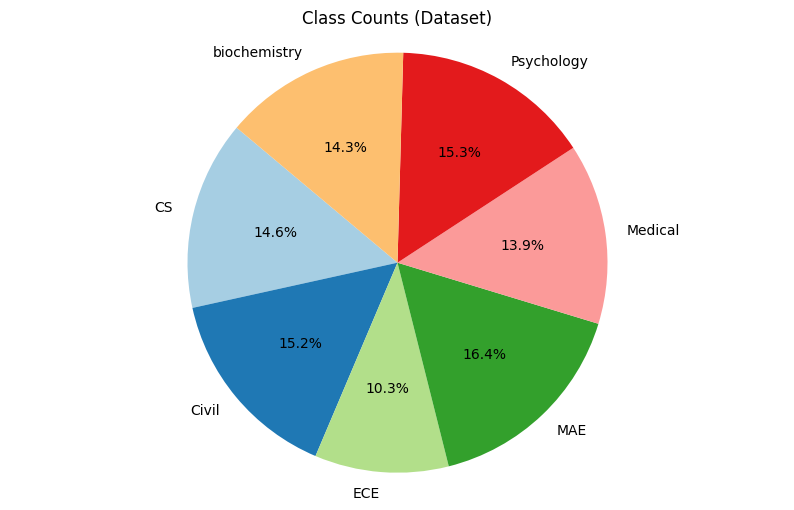

The label CS has 2758 records in the dataset.
The label Civil has 2870 records in the dataset.
The label ECE has 1952 records in the dataset.
The label MAE has 3100 records in the dataset.
The label Medical has 2634 records in the dataset.
The label Psychology has 2906 records in the dataset.
The label biochemistry has 2712 records in the dataset.


In [7]:
# Visualize domain counts in dataset
plt.figure(figsize=(10, 6))
plt.title("Class Counts (Dataset)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')
plt.show()

for i, label in enumerate(labels):
    print("The label", label, "has", labelCounts[i], "records in the dataset.")

In [8]:
labeled_data_shuffled = sklearn.utils.shuffle(labeled_data)
abstracts_shuffled = labeled_data_shuffled['Abstract'].values
keywords_shuffled = labeled_data_shuffled['Keywords'].values
domains_shuffled = labeled_data_shuffled['Domain'].values
allLabels_shuffled = labeled_data_shuffled['Label'].values
allLabels_digit_shuffled = allLabels_shuffled.astype(int)

In [9]:
print(np.shape(labeled_data_shuffled))
print(np.shape(abstracts_shuffled))
print(np.shape(keywords_shuffled))
print(np.shape(domains_shuffled))

print(labeled_data_shuffled['combined_text'][0])

(18932, 5)
(18932,)
(18932,)
(18932,)
 interview anxiety interview performance person perception job interview         [SEP] the aim of this study was to investigate a the behavioral cues that are displayed by and trait judgments formed about anxious interviewees and b why anxious interviewees receive lower interview performance ratings the behavioral expression of interview anxiety model was created as a conceptual framework to explore these relations we videotaped and transcribed mock job interviews obtained ratings of interview anxiety and interview performance and trained raters to assess several verbal and nonverbal cues and trait judgments the results indicated that few behavioral cues but several traits were related to interviewee and interviewer ratings of interview anxiety two factors emerged from our factor analysis on the trait judgmentsassertiveness and interpersonal warmth mediation analyses were performed and indicated that assertiveness and interpersonal warmth mediated 

In [ ]:
train_data, test_data = train_test_split(labeled_data_shuffled, test_size=0.2, random_state=42)
print(np.shape(train_data))
print(np.shape(test_data))

_, val_data = train_test_split(test_data, test_size=0.5, random_state=42)
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(val_data))



(15145, 5)
(3787, 5)
(15145, 5)
(3787, 5)
(1894, 5)


In [11]:
tokenizer = AutoTokenizer.from_pretrained("bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16")

/opt/conda/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [12]:
abstractslbltrain = train_data['Abstract']
keywordsslbltrain = train_data['Keywords']
domainlbltrain = train_data['Domain']
lblstrain = train_data['Label']

In [13]:
print(np.shape(labeled_data))
print(labeled_data.columns)

(18932, 5)
Index(['Label', 'Domain', 'Keywords', 'Abstract', 'combined_text'], dtype='object')


In [14]:
labels = np.unique(domainlbltrain, return_counts=True)[0]
labelCounts=  np.unique(domainlbltrain, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [2223 2318 1595 2404 2128 2319 2158]


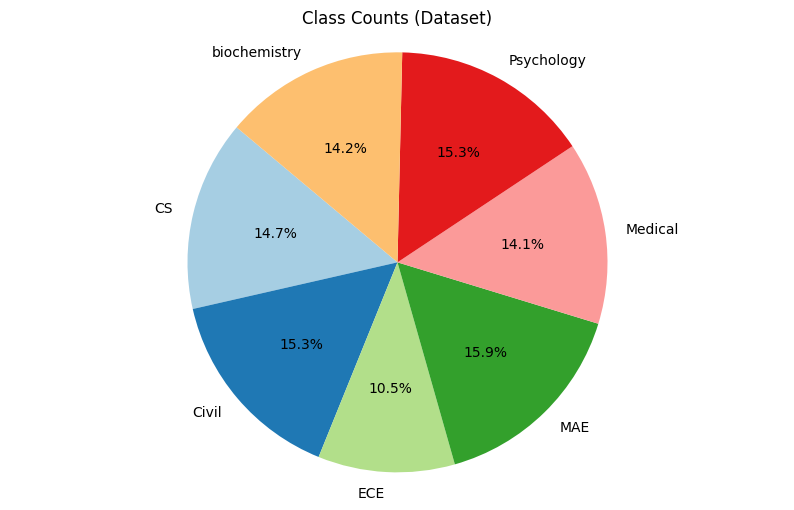

The label CS has 2223 records in the dataset.
The label Civil has 2318 records in the dataset.
The label ECE has 1595 records in the dataset.
The label MAE has 2404 records in the dataset.
The label Medical has 2128 records in the dataset.
The label Psychology has 2319 records in the dataset.
The label biochemistry has 2158 records in the dataset.


In [ ]:
plt.figure(figsize=(10, 6))
plt.title("Class Counts (Dataset)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')
plt.show()

for i, label in enumerate(labels):
    print("The label", label, "has", labelCounts[i], "records in the dataset.")

In [16]:
abstractslbltest = test_data['Abstract']
keywordsslbltest = test_data['Keywords']
domainlbltest = test_data['Domain']
lblstest = test_data['Label']

In [17]:
labels = np.unique(domainlbltest, return_counts=True)[0]
labelCounts=  np.unique(domainlbltest, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [535 552 357 696 506 587 554]


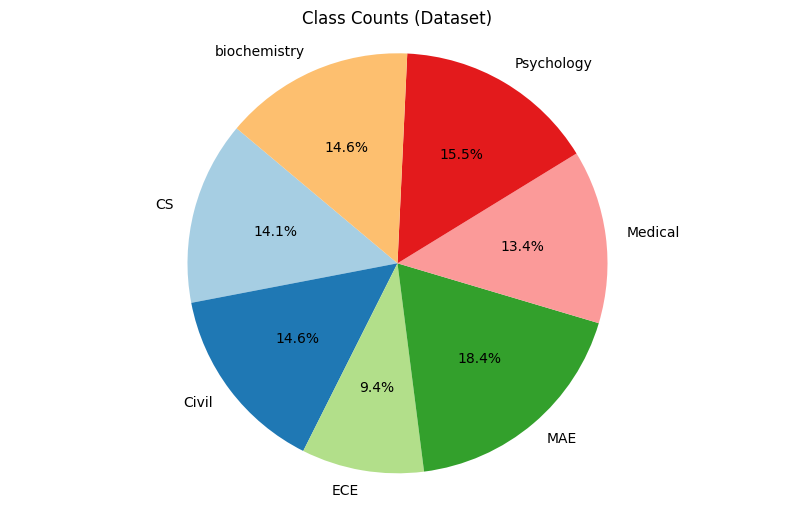

The label CS has 535 records in the dataset.
The label Civil has 552 records in the dataset.
The label ECE has 357 records in the dataset.
The label MAE has 696 records in the dataset.
The label Medical has 506 records in the dataset.
The label Psychology has 587 records in the dataset.
The label biochemistry has 554 records in the dataset.


In [18]:
# Visualize domain counts in dataset
plt.figure(figsize=(10, 6))
plt.title("Class Counts (Dataset)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')
plt.show()

for i, label in enumerate(labels):
    print("The label", label, "has", labelCounts[i], "records in the dataset.")

In [19]:
abstractslblval = val_data['Abstract']
keywordsslblval = val_data['Keywords']
domainlblval = val_data['Domain']
lblsval = val_data['Label']

In [20]:
labels = np.unique(domainlblval, return_counts=True)[0]
labelCounts=  np.unique(domainlblval, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

Labels  ['CS' 'Civil' 'ECE' 'MAE' 'Medical' 'Psychology' 'biochemistry']
Label counts  [266 278 171 360 259 286 274]


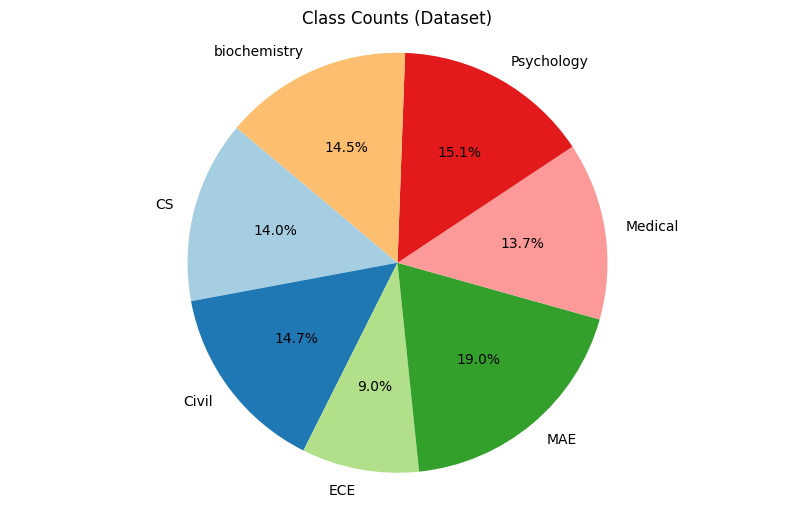

The label CS has 266 records in the dataset.
The label Civil has 278 records in the dataset.
The label ECE has 171 records in the dataset.
The label MAE has 360 records in the dataset.
The label Medical has 259 records in the dataset.
The label Psychology has 286 records in the dataset.
The label biochemistry has 274 records in the dataset.


In [21]:
# Visualize domain counts in dataset
plt.figure(figsize=(10, 6))
plt.title("Class Counts (Dataset)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')
plt.show()

for i, label in enumerate(labels):
    print("The label", label, "has", labelCounts[i], "records in the dataset.")

In [ ]:
def encode_data(data, tokenizer, max_length=128, labeled=True):
    inputs = tokenizer(
        data['combined_text'].tolist(),
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    if labeled and 'Label' in data.columns:
        labels = torch.tensor(data['Label'].values.astype(int))
        return TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)
    else:
        return TensorDataset(inputs['input_ids'], inputs['attention_mask'])


In [23]:
train_dataset = encode_data(train_data, tokenizer)
val_dataset = encode_data(val_data, tokenizer)
test_dataset = encode_data(test_data, tokenizer)

In [24]:
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=32)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=32)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=32)

In [25]:
print(len(np.unique(train_data['Label'])))
model = AutoModelForSequenceClassification.from_pretrained("bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16", num_labels=len(np.unique(train_data['Label'])))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

7


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1

In [26]:
def calculate_metrics_f(valType, predictions, true_labels):
    if valType == 'test':
        cm = confusion_matrix(true_labels, predictions)
        report = classification_report(true_labels, predictions)
        f1_micro = f1_score(true_labels, predictions, average='micro')
        print("\nClassification Report:\n", report)
        return f1_micro
    elif valType == 'val':
        f1_micro = f1_score(true_labels, predictions, average='micro')
        return f1_micro

In [ ]:
def calculate_metrics(valType, predictions, true_labels):
    # Confusion matrix
    if(valType == 'test'):
        cm = confusion_matrix(true_labels, predictions)
        print("Confusion Matrix:\n", cm)

        report = classification_report(true_labels, predictions, target_names=[str(i) for i in range(len(np.unique(true_labels)))])
        print("\nClassification Report:\n", report)

        f1_macro = f1_score(true_labels, predictions, average='macro')
        f1_micro = f1_score(true_labels, predictions, average='micro')
        f1_weighted = f1_score(true_labels, predictions, average='weighted')

        precision_macro = precision_score(true_labels, predictions, average='macro')
        precision_micro = precision_score(true_labels, predictions, average='micro')
        precision_weighted = precision_score(true_labels, predictions, average='weighted')

        recall_macro = recall_score(true_labels, predictions, average='macro')
        recall_micro = recall_score(true_labels, predictions, average='micro')
        recall_weighted = recall_score(true_labels, predictions, average='weighted')

        print(f"Macro F1 Score: {f1_macro}")
        print(f"Micro F1 Score: {f1_micro}")
        print(f"Weighted F1 Score: {f1_weighted}")

        print(f"Macro Precision: {precision_macro}")
        print(f"Micro Precision: {precision_micro}")
        print(f"Weighted Precision: {precision_weighted}")

        print(f"Macro Recall: {recall_macro}")
        print(f"Micro Recall: {recall_micro}")
        print(f"Weighted Recall: {recall_weighted}")

    elif(valType == 'val'):
        cm = confusion_matrix(true_labels, predictions)
        f1_macro = f1_score(true_labels, predictions, average='macro')
        f1_micro = f1_score(true_labels, predictions, average='micro')
        f1_weighted = f1_score(true_labels, predictions, average='weighted')

        precision_macro = precision_score(true_labels, predictions, average='macro')
        precision_micro = precision_score(true_labels, predictions, average='micro')
        precision_weighted = precision_score(true_labels, predictions, average='weighted')

        recall_macro = recall_score(true_labels, predictions, average='macro')
        recall_micro = recall_score(true_labels, predictions, average='micro')
        recall_weighted = recall_score(true_labels, predictions, average='weighted')
        # print('Val Micro F1:', f1_micro)
        return f1_micro

In [ ]:

epochs = 20
learning_rates = [2e-5, 5e-6, 1e-6, 2e-6]
early_stopping_patience = 3
best_val_f1 = 0
early_stopping_counter = 0

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    optimizer = AdamW(model.parameters(), lr=lr, eps=1e-8)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0.1 * total_steps, num_training_steps=total_steps)

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch"):
            batch = tuple(t.to(device) for t in batch)
            input_ids, input_mask, labels = batch
            model.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=input_mask, labels=labels)
            loss = outputs.loss
            total_train_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()
        avg_train_loss = total_train_loss / len(train_dataloader)
        print(f"Train Loss: {avg_train_loss}")

        # Validation
        model.eval()
        predictions, true_labels = [], []
        for batch in val_dataloader:
            batch = tuple(t.to(device) for t in batch)
            input_ids, input_mask, labels = batch
            with torch.no_grad():
                outputs = model(input_ids=input_ids, attention_mask=input_mask)
            logits = outputs.logits.detach().cpu().numpy()
            batch_predictions = np.argmax(logits, axis=1)
            predictions.extend(batch_predictions)
            true_labels.extend(labels.to('cpu').numpy())
        val_f1 = f1_score(true_labels, predictions, average='micro')
        print(f"Validation Micro F1: {val_f1}")
        val_micro_f1 = calculate_metrics_f('val', predictions, true_labels)
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss}, Val Micro F1: {val_micro_f1}")

        # Early stopping check
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            early_stopping_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
            print("Best model saved.")
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print("Early stopping applied.")
                break

model.load_state_dict(torch.load('best_model.pth'))
print("Best model loaded.")


Training with learning rate: 2e-05


/opt/conda/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/20: 100%|██████████| 474/474 [57:01<00:00,  7.22s/batch]


Train Loss: 1.3097435887981568
Validation Micro F1: 0.8606124604012672
Epoch 1/20, Train Loss: 1.3097435887981568, Val Micro F1: 0.8606124604012672
Best model saved.


Epoch 2/20: 100%|██████████| 474/474 [55:45<00:00,  7.06s/batch]


Train Loss: 0.327563259341923
Validation Micro F1: 0.9081309398099261
Epoch 2/20, Train Loss: 0.327563259341923, Val Micro F1: 0.9081309398099261
Best model saved.


Epoch 3/20: 100%|██████████| 474/474 [55:49<00:00,  7.07s/batch]


Train Loss: 0.21226077000237215
Validation Micro F1: 0.9065469904963042
Epoch 3/20, Train Loss: 0.21226077000237215, Val Micro F1: 0.9065469904963042


Epoch 4/20: 100%|██████████| 474/474 [55:53<00:00,  7.08s/batch]


Train Loss: 0.12512053626506955
Validation Micro F1: 0.9054910242872228
Epoch 4/20, Train Loss: 0.12512053626506955, Val Micro F1: 0.9054910242872228


Epoch 5/20: 100%|██████████| 474/474 [55:00<00:00,  6.96s/batch]


Train Loss: 0.07384417540558814


/opt/conda/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Validation Micro F1: 0.8996832101372756
Epoch 5/20, Train Loss: 0.07384417540558814, Val Micro F1: 0.8996832101372756
Early stopping applied.

Training with learning rate: 5e-06


Epoch 1/20: 100%|██████████| 474/474 [54:48<00:00,  6.94s/batch]


Train Loss: 0.030092660446979405
Validation Micro F1: 0.9091869060190074
Epoch 1/20, Train Loss: 0.030092660446979405, Val Micro F1: 0.9091869060190074
Best model saved.


Epoch 2/20: 100%|██████████| 474/474 [54:36<00:00,  6.91s/batch]


Train Loss: 0.0204471677494086
Validation Micro F1: 0.9123548046462513
Epoch 2/20, Train Loss: 0.0204471677494086, Val Micro F1: 0.9123548046462513
Best model saved.


Epoch 3/20: 100%|██████████| 474/474 [55:16<00:00,  7.00s/batch]


Train Loss: 0.012395728888743624
Validation Micro F1: 0.9107708553326294
Epoch 3/20, Train Loss: 0.012395728888743624, Val Micro F1: 0.9107708553326294


Epoch 4/20: 100%|██████████| 474/474 [55:21<00:00,  7.01s/batch]


Train Loss: 0.009996650387697072
Validation Micro F1: 0.9107708553326294
Epoch 4/20, Train Loss: 0.009996650387697072, Val Micro F1: 0.9107708553326294


Epoch 5/20: 100%|██████████| 474/474 [56:17<00:00,  7.13s/batch]


Train Loss: 0.008260477224169869
Validation Micro F1: 0.912882787750792
Epoch 5/20, Train Loss: 0.008260477224169869, Val Micro F1: 0.912882787750792
Best model saved.


Epoch 6/20: 100%|██████████| 474/474 [56:15<00:00,  7.12s/batch]


Train Loss: 0.00529112706792478
Validation Micro F1: 0.9107708553326294
Epoch 6/20, Train Loss: 0.00529112706792478, Val Micro F1: 0.9107708553326294


Epoch 7/20: 100%|██████████| 474/474 [55:43<00:00,  7.05s/batch]


Train Loss: 0.003953675871785192
Validation Micro F1: 0.9149947201689546
Epoch 7/20, Train Loss: 0.003953675871785192, Val Micro F1: 0.9149947201689546
Best model saved.


Epoch 8/20: 100%|██████████| 474/474 [56:54<00:00,  7.20s/batch]


Train Loss: 0.002612928506898112
Validation Micro F1: 0.9123548046462513
Epoch 8/20, Train Loss: 0.002612928506898112, Val Micro F1: 0.9123548046462513


Epoch 9/20: 100%|██████████| 474/474 [56:46<00:00,  7.19s/batch]


Train Loss: 0.003315644259151967
Validation Micro F1: 0.91129883843717
Epoch 9/20, Train Loss: 0.003315644259151967, Val Micro F1: 0.91129883843717


Epoch 10/20: 100%|██████████| 474/474 [56:00<00:00,  7.09s/batch]


Train Loss: 0.0029380469675566842


/opt/conda/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Validation Micro F1: 0.9123548046462513
Epoch 10/20, Train Loss: 0.0029380469675566842, Val Micro F1: 0.9123548046462513
Early stopping applied.

Training with learning rate: 1e-06


Epoch 1/20: 100%|██████████| 474/474 [56:09<00:00,  7.11s/batch]


Train Loss: 0.002267460330512978


/opt/conda/lib/python3.11/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Validation Micro F1: 0.9139387539598732
Epoch 1/20, Train Loss: 0.002267460330512978, Val Micro F1: 0.9139387539598732
Early stopping applied.

Training with learning rate: 2e-06


Epoch 1/20: 100%|██████████| 474/474 [56:08<00:00,  7.11s/batch]


Train Loss: 0.0015131834397565983
Validation Micro F1: 0.9118268215417107
Epoch 1/20, Train Loss: 0.0015131834397565983, Val Micro F1: 0.9118268215417107
Early stopping applied.


/tmp/ipykernel_1467080/2884164286.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Best model loaded.


In [ ]:
# Evaluation
model.eval()
predictions = []
true_labels = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, labels = batch

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=input_mask)
        logits = outputs.logits

    logits = logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()

    batch_predictions = np.argmax(logits, axis=1)
    predictions.extend(batch_predictions)
    true_labels.extend(label_ids)

calculate_metrics('test', predictions, true_labels)

Confusion Matrix:
 [[496  12   2  10  12   0   3]
 [  8 332   0  14   3   0   0]
 [  5   1 545   1   9  22   4]
 [ 10  12   0 648  21   0   5]
 [ 13   2   1   7 523   2   4]
 [  3   1  42   1   2 425  32]
 [  5   1   2   2   4  31 509]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.92       535
           1       0.92      0.93      0.92       357
           2       0.92      0.93      0.92       587
           3       0.95      0.93      0.94       696
           4       0.91      0.95      0.93       552
           5       0.89      0.84      0.86       506
           6       0.91      0.92      0.92       554

    accuracy                           0.92      3787
   macro avg       0.92      0.92      0.92      3787
weighted avg       0.92      0.92      0.92      3787

Macro F1 Score: 0.9170311682100544
Micro F1 Score: 0.9184050699762345
Weighted F1 Score: 0.9182083235938835
Macro Precision: 0.91684860814839

In [ ]:
print("\nTest Metrics:")
print("Confusion Matrix:\n", confusion_matrix(true_labels, predictions))
print("Classification Report:\n", classification_report(true_labels, predictions))
print("Macro F1:", f1_score(true_labels, predictions, average='macro'))
print("Micro F1:", f1_score(true_labels, predictions, average='micro'))
print("Weighted F1:", f1_score(true_labels, predictions, average='weighted'))


Test Metrics:
Confusion Matrix:
 [[496  12   2  10  12   0   3]
 [  8 332   0  14   3   0   0]
 [  5   1 545   1   9  22   4]
 [ 10  12   0 648  21   0   5]
 [ 13   2   1   7 523   2   4]
 [  3   1  42   1   2 425  32]
 [  5   1   2   2   4  31 509]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.92       535
           1       0.92      0.93      0.92       357
           2       0.92      0.93      0.92       587
           3       0.95      0.93      0.94       696
           4       0.91      0.95      0.93       552
           5       0.89      0.84      0.86       506
           6       0.91      0.92      0.92       554

    accuracy                           0.92      3787
   macro avg       0.92      0.92      0.92      3787
weighted avg       0.92      0.92      0.92      3787

Macro F1: 0.9170311682100544
Micro F1: 0.9184050699762345
Weighted F1: 0.9182083235938835


In [31]:
for name, param in model.named_parameters():
    if not param.is_contiguous():
        param.data = param.data.contiguous()
model.save_pretrained('BlueBERT_WoS_53949_records')

In [32]:
print('End of the runtime!')

End of the runtime!
